In [1]:
# COMPLETAR OS DADOS METEROLÓGICOS DOS PEFIS DE PRESSÃO

In [2]:
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import shapely
from shapely.strtree import STRtree
from shapely.geometry import box

In [3]:
xr.set_options(display_max_rows=50, display_width=150)

In [4]:
time_list = pd.read_csv(r"..\..\Data\Interim\Meteorological_data\time_list.csv")["datetime"].apply(pd.to_datetime).tolist()

date_list = [t.date() for t in time_list]
date_list = np.array(date_list, dtype='datetime64[D]')
print(date_list[:5])

['2015-08-03' '2015-08-03' '2015-08-03' '2015-08-03' '2015-08-03']


In [5]:
shp = gpd.read_file(r"../../Data/Interim/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_valid.shp")
shp = shp.to_crs("EPSG:4326")

c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


In [6]:
master_folder = r"../../Data/Raw/Meteorological_data/ERA5_Land_downloads"
output_folder = r"../../Data/Interim/Meteorological_data"
os.makedirs(output_folder, exist_ok=True)

# Caminhos dos ficheiros de saída
out_SL = os.path.join(output_folder, "meteo_paths_SL.txt")
out_PL = os.path.join(output_folder, "meteo_paths_PL.txt")
out_Land = os.path.join(output_folder, "meteo_paths_Land.txt")
out_GP = os.path.join(output_folder, "meteo_paths_GP.txt")
out_Fb = os.path.join(output_folder, "meteo_paths_Fb.txt")
out_FWI = os.path.join(output_folder, "meteo_paths_FWI.txt")

# Abre todos de uma vez
with open(out_SL, "w", encoding="utf-8") as fSL, \
     open(out_PL, "w", encoding="utf-8") as fPL, \
     open(out_Land, "w", encoding="utf-8") as fLand, \
     open(out_GP, "w", encoding="utf-8") as fGP, \
     open(out_Fb, "w", encoding="utf-8") as fFb, \
     open(out_FWI, "w", encoding="utf-8") as fFWI:

    count_SL = count_PL = count_Land = count_GP = count_Fb = count_FWI = 0

    for root, dirs, files in os.walk(master_folder):
        for file in files:
            if not file.endswith(".nc"):
                continue

            full_path = os.path.join(root, file)

            if "_SL_" in file:
                fSL.write(full_path + "\n")
                count_SL += 1
            elif "_PL_" in file:
                fPL.write(full_path + "\n")
                count_PL += 1
            elif "_Land_" in file:
                fLand.write(full_path + "\n")
                count_Land += 1
            elif "_GP_" in file:
                fGP.write(full_path + "\n")
                count_GP += 1
            elif "_Fb_" in file:
                fFb.write(full_path + "\n")
                count_Fb += 1
            elif "_FWI_" in file:
                fFWI.write(full_path + "\n")
                count_FWI += 1

print(f"Total SL: {count_SL} | PL: {count_PL} | Land: {count_Land} | GP: {count_GP} | Fb: {count_Fb} | FWI: {count_FWI}")

Total SL: 35 | PL: 35 | Land: 35 | GP: 1 | Fb: 35 | FWI: 28


In [7]:
import psutil, os

process = psutil.Process(os.getpid())
print(f"RAM usada: {process.memory_info().rss / (1024**2):.2f} MB")


RAM usada: 218.62 MB


In [ ]:
# Unir os diferentes NetCDFs

with open("../../Data/Interim/Meteorological_data/meteo_paths_SL.txt", "r", encoding="utf-8") as f:
    meteo_paths_SL = [line.strip() for line in f if line.strip()]

ds_SL = xr.open_mfdataset(
    meteo_paths_SL,
    combine="by_coords",
    parallel=True,
    engine="netcdf4" 
)

ds_SL = ds_SL.drop_vars(["expver", "number"])

ds_SL = ds_SL.sel(valid_time=[t for t in time_list if t in ds_SL.valid_time.values])

out_path = r"../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_SL.nc"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
ds_SL.to_netcdf(out_path)

print(ds_SL)

In [ ]:
with open("../../Data/Interim/Meteorological_data/meteo_paths_PL.txt", "r", encoding="utf-8") as f:
    meteo_paths_PL = [line.strip() for line in f if line.strip()]

ds_PL = xr.open_mfdataset(
    meteo_paths_PL,
    combine="by_coords",
    parallel=True,
    
)

ds_PL = ds_PL.drop_vars(["expver", "number"])

ds_PL = ds_PL.sel(valid_time=[t for t in time_list if t in ds_PL.valid_time.values])

out_path = r"../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_PL.nc"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
ds_PL.to_netcdf(out_path)

print(ds_PL)

<xarray.Dataset> Size: 127MB
Dimensions:         (valid_time: 2486, pressure_level: 5, latitude: 25, longitude: 17)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * pressure_level  (pressure_level) float64 40B 950.0 850.0 700.0 500.0 300.0
  * latitude        (latitude) float64 200B 43.0 42.75 42.5 42.25 42.0 41.75 41.5 41.25 41.0 ... 39.0 38.75 38.5 38.25 38.0 37.75 37.5 37.25 37.0
  * longitude       (longitude) float64 136B -10.0 -9.75 -9.5 -9.25 -9.0 -8.75 -8.5 -8.25 -8.0 -7.75 -7.5 -7.25 -7.0 -6.75 -6.5 -6.25 -6.0
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 21MB dask.array<chunksize=(139, 5, 25, 17), meta=np.ndarray>
    r               (valid_time, pressure_level, latitude, longitude) float32 21MB dask.array<chunksize=(139, 5, 25, 17), meta=np.ndarray>
    t               (valid_time, pressure_level, latitude, longitude) float3

In [ ]:
with open("../../Data/Interim/Meteorological_data/meteo_paths_Land.txt", "r", encoding="utf-8") as f:
    meteo_paths_Land = [line.strip() for line in f if line.strip()]
    
ds_Land = xr.open_mfdataset(
    meteo_paths_Land, 
    combine="by_coords", 
    parallel=True,
    engine="netcdf4"
)

ds_Land = ds_Land.drop_vars(["expver", "number"])

print(ds_Land)

<xarray.Dataset> Size: 244MB
Dimensions:     (valid_time: 4872, latitude: 61, longitude: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 39kB 2015-08-03 2015-08-03T01:00:00 2015-08-03T02:00:00 ... 2025-08-23T22:00:00 2025-08-23T23:00:00
  * latitude    (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude   (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    d2m         (valid_time, latitude, longitude) float32 49MB dask.array<chunksize=(168, 61, 41), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 49MB dask.array<chunksize=(168, 61, 41), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 49MB dask.array<chunksize=(168, 61, 41), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 49MB dask.array<chunksize=(1

In [ ]:
with open("../../Data/Interim/Meteorological_data/meteo_paths_GP.txt", "r", encoding="utf-8") as f:
    meteo_paths_GP = [line.strip() for line in f if line.strip()]
    
ds_GP = xr.open_mfdataset(
    meteo_paths_GP, 
    combine="by_coords", 
    parallel=True
    )

ds_GP = ds_GP.assign_coords(longitude = (((ds_GP.longitude + 180) % 360) - 180))
ds_GP = ds_GP.sortby("longitude")  # garante ordem crescente

ds_GP = ds_GP.assign_coords({
    'latitude': ds_GP.latitude.astype('float64'),
    'longitude': ds_GP.longitude.astype('float64')
})

ds_GP = ds_GP.astype({'z': 'float32'})

print(ds_GP)

<xarray.Dataset> Size: 11kB
Dimensions:    (time: 1, latitude: 61, longitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 8B 2013-08-09T12:00:00
  * latitude   (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude  (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    z          (time, latitude, longitude) float32 10kB dask.array<chunksize=(1, 61, 41), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_0.1x0.1.grib2_v4.nc geo_1279l4_0.1x0.1.grib2_v4_unpack.nc\n2020-06-12 ...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1


In [ ]:
# Unir ds_Land a ds_GP

ds_GP = ds_GP.isel(time=0).drop_vars("time", errors="ignore")

ds_GP = ds_GP.expand_dims({"valid_time": ds_Land.valid_time})

ds_GP = ds_GP.reindex_like(ds_Land, method='nearest')

ds_Land = xr.merge([ds_Land, ds_GP], join="exact")

ds_Land = ds_Land.drop_vars(["expver", "number"], errors="ignore")

ds_Land = ds_Land.sel(valid_time=[t for t in time_list if t in ds_Land.valid_time.values])

print(ds_Land)

out_path = r"../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_Land.nc"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
ds_Land.to_netcdf(out_path)

print("✅ NetCDF Era 5 Land consolidado guardado")

ds_GP.close()

<xarray.Dataset> Size: 149MB
Dimensions:     (valid_time: 2486, latitude: 61, longitude: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude    (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude   (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    d2m         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(139, 61, 41), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(139, 61, 41), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(139, 61, 41), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(139, 61, 41)

✅ NetCDF Era 5 Land consolidado guardado


In [ ]:
# Unir o ds_SL ao ds_Land

ds_SL = ds_SL.interp(
    latitude=ds_Land.latitude,
    longitude=ds_Land.longitude,
    method="linear"
)

# Primeiro tenta com ds_Land
ds_SL = xr.merge([ds_SL, ds_Land], join='left')

print(ds_SL)

<xarray.Dataset> Size: 497MB
Dimensions:     (valid_time: 2486, latitude: 61, longitude: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude    (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude   (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    u100        (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(138, 61, 41), meta=np.ndarray>
    v100        (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(138, 61, 41), meta=np.ndarray>
    cbh         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(138, 61, 41), meta=np.ndarray>
    hcc         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(138, 61, 41)

In [ ]:
with open("../../Data/Interim/Meteorological_data/meteo_paths_Fb.txt", "r", encoding="utf-8") as f:
    meteo_paths_Fb = [line.strip() for line in f if line.strip()]
    
ds_Fb = xr.open_mfdataset(
    meteo_paths_Fb,
    combine="by_coords",
    parallel=True,
    
)

ds_Fb = ds_Fb.drop_vars(["expver", "number"])

ds_Fb = ds_Fb.sel(valid_time=[t for t in time_list if t in ds_Fb.valid_time.values])

out_path = r"../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_Fb.nc"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
ds_Fb.to_netcdf(out_path)

print(ds_Fb)

RuntimeError: NetCDF: HDF error

In [ ]:
ds_Fb = ds_Fb.interp(
    latitude=ds_Land.latitude,
    longitude=ds_Land.longitude,
    method="linear"
)

# Depois preenche missing com ds_Fb
ds_SL = ds_SL.fillna(ds_Fb)

: 

In [ ]:
out_path = r"../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_Land_SL.nc"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
ds_SL.to_netcdf(out_path)

In [ ]:
ds_PL = ds_PL.interp(
    latitude=ds_SL.latitude, 
    longitude=ds_SL.longitude,
    method='linear'
)

print(ds_PL)

<xarray.Dataset> Size: 746MB
Dimensions:         (valid_time: 2486, pressure_level: 5, latitude: 61, longitude: 41)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * pressure_level  (pressure_level) float64 40B 950.0 850.0 700.0 500.0 300.0
  * latitude        (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude       (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 124MB dask.array<chunksize=(139, 5, 61, 41), meta=np.ndarray>
    r               (valid_time, pressure_level, latitude, longitude) float32 124MB dask.array<chunksize=(139, 5, 61, 41), meta=np.ndarray>
    t               (valid_time, pressure_level, latitude, lo

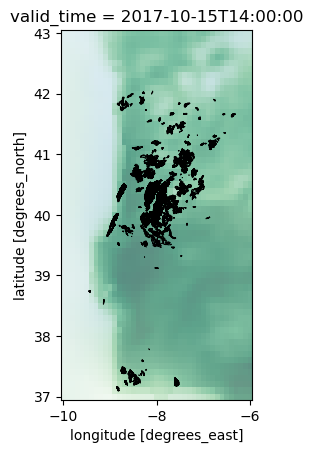

In [ ]:
import matplotlib.pyplot as plt

# Plot dos dados de vento
ds_SL.u100.sel(valid_time='2017-10-15 14:00:00').plot(cmap='Blues', alpha=0.5, add_colorbar=False)
#ds_Fb.u10.sel(valid_time='2017-10-15 14:00:00').plot(cmap='Reds', alpha=0.5, add_colorbar=False)
ds_SL.t2m.sel(valid_time='2017-10-15 14:00:00').plot(cmap='Greens', alpha=0.5, add_colorbar=False)

# Plot do shapefile
shp.plot(ax=plt.gca(), color='none', edgecolor='black', linewidth=0.5)

plt.show()

In [ ]:
# Unir os diferentes NetCDFs

with open("../../Data/Interim/Meteorological_data/meteo_paths_FWI.txt", "r", encoding="utf-8") as f:
    meteo_paths_FWI = [line.strip() for line in f if line.strip()]

ds_FWI = xr.open_mfdataset(
    meteo_paths_FWI,
    combine="by_coords",
    parallel=True,
    engine="netcdf4" 
)

ds_FWI = ds_FWI.drop_vars(["surface"])
    
ds_FWI = ds_FWI.sel(valid_time=[t for t in date_list if t in ds_FWI.valid_time.values])

print(ds_FWI)

<xarray.Dataset> Size: 16GB
Dimensions:     (valid_time: 2486, values: 542080)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 2015-08-03 2015-08-03 2015-08-03 2015-08-03 ... 2025-08-23 2025-08-23 2025-08-23 2025-08-23
    latitude    (values) float64 4MB dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude   (values) float64 4MB dask.array<chunksize=(542080,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    fbupinx     (valid_time, values) float32 5GB dask.array<chunksize=(5, 271040), meta=np.ndarray>
    ffmcode     (valid_time, values) float32 5GB dask.array<chunksize=(5, 271040), meta=np.ndarray>
    fwinx       (valid_time, values) float32 5GB dask.array<chunksize=(5, 271040), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:

In [ ]:
# Máscara super simples para Portugal - CORRIGIDA
lat = ds_FWI.latitude.values
lon = ds_FWI.longitude.values

# Portugal continental no sistema 0-360°
# -9.5°W = 350.5°E, -6°W = 354°E
mask_portugal = (lat >= 36) & (lat <= 43) & (lon >= 350) & (lon <= 354)

# Aplicar a máscara
ds_FWI = ds_FWI.isel(values=mask_portugal)

dates = ds_FWI.valid_time.dt.date

# Agrupar por data e calcular média
ds_FWI = ds_FWI.groupby(dates).mean().rename({'date': 'valid_time'})
ds_FWI['valid_time'] = pd.to_datetime(ds_FWI.valid_time.values)

print(ds_FWI)

<xarray.Dataset> Size: 712kB
Dimensions:     (valid_time: 202, values: 291)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2015-08-03 2015-08-04 2015-08-08 2015-08-09 2015-08-10 ... 2025-08-20 2025-08-21 2025-08-22 2025-08-23
    latitude    (values) float64 2kB dask.array<chunksize=(291,), meta=np.ndarray>
    longitude   (values) float64 2kB dask.array<chunksize=(291,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    fbupinx     (valid_time, values) float32 235kB dask.array<chunksize=(1, 291), meta=np.ndarray>
    ffmcode     (valid_time, values) float32 235kB dask.array<chunksize=(1, 291), meta=np.ndarray>
    fwinx       (valid_time, values) float32 235kB dask.array<chunksize=(1, 291), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:  

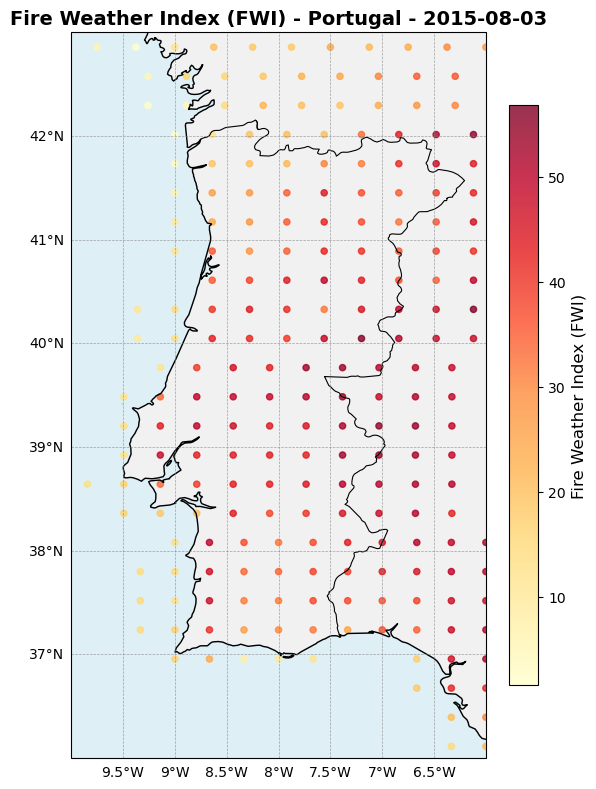

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Plot simples de todos os dados FWI para Portugal
fig, ax = plt.subplots(1, 1, figsize=(12, 8), 
                      subplot_kw={'projection': ccrs.PlateCarree()})

# Extrair coordenadas e dados do dataset de Portugal
lons = ds_FWI.longitude.values
lats = ds_FWI.latitude.values

# Pegar apenas o primeiro tempo para visualização
fwi_data = ds_FWI['fwinx'].isel(valid_time=0).values

# Aplicar máscara para valores válidos
mask = ~np.isnan(fwi_data)

# Scatter plot
scatter = ax.scatter(lons[mask], lats[mask], 
                    c=fwi_data[mask], 
                    cmap='YlOrRd', s=20, alpha=0.8)

# Elementos do mapa - foco em Portugal
ax.set_extent([-10, -6, 36, 43], crs=ccrs.PlateCarree())  # Zoom em Portugal
ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)
ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.4)
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.3)

# Grades mais detalhadas para Portugal
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.7, 
                 color='gray', linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Barra de cores
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', 
                   pad=0.02, shrink=0.8)
cbar.set_label('Fire Weather Index (FWI)', fontsize=12)

ax.set_title('Fire Weather Index (FWI) - Portugal - 2015-08-03',
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
out_path = r"../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_FWI.nc"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
ds_FWI.to_netcdf(out_path)

print(ds_FWI)

<xarray.Dataset> Size: 712kB
Dimensions:     (valid_time: 202, values: 291)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2015-08-03 2015-08-04 2015-08-08 2015-08-09 2015-08-10 ... 2025-08-20 2025-08-21 2025-08-22 2025-08-23
    latitude    (values) float64 2kB dask.array<chunksize=(291,), meta=np.ndarray>
    longitude   (values) float64 2kB dask.array<chunksize=(291,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    fbupinx     (valid_time, values) float32 235kB dask.array<chunksize=(1, 291), meta=np.ndarray>
    ffmcode     (valid_time, values) float32 235kB dask.array<chunksize=(1, 291), meta=np.ndarray>
    fwinx       (valid_time, values) float32 235kB dask.array<chunksize=(1, 291), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:  

In [ ]:
start_time = ds_FWI.valid_time.min().values
end_time = ds_FWI.valid_time.max().values

full_hourly_index = pd.date_range(start=start_time, end=end_time, freq='h')

# Reindexar para frequência horária
ds_FWI = ds_FWI.reindex(valid_time=full_hourly_index)

# Preencher os valores horários com os valores diários
# Usamos forward fill para preencher todas as horas com o valor do dia
ds_FWI = ds_FWI.ffill('valid_time')

print(ds_FWI)

<xarray.Dataset> Size: 309MB
Dimensions:     (valid_time: 88153, values: 291)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 705kB 2015-08-03 2015-08-03T01:00:00 2015-08-03T02:00:00 ... 2025-08-22T23:00:00 2025-08-23
    latitude    (values) float64 2kB dask.array<chunksize=(291,), meta=np.ndarray>
    longitude   (values) float64 2kB dask.array<chunksize=(291,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    fbupinx     (valid_time, values) float32 103MB dask.array<chunksize=(1, 291), meta=np.ndarray>
    ffmcode     (valid_time, values) float32 103MB dask.array<chunksize=(1, 291), meta=np.ndarray>
    fwinx       (valid_time, values) float32 103MB dask.array<chunksize=(1, 291), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Eu

In [ ]:
print(ds_Land)
print(ds_FWI)

# Reestruturar ds_FWI para ter dimensões de latitude e longitude
ds_FWI_restructured = ds_FWI.set_index(values=["latitude", "longitude"]).unstack("values")

print(ds_FWI_restructured)

# Agora podemos fazer a interpolação diretamente sem renomear
ds_FWI_interp = ds_FWI_restructured.interp(
    latitude=ds_Land.latitude,
    longitude=ds_Land.longitude,
    method="linear"
)

# Mesclar com ds_SL
ds_SL = xr.merge([ds_SL, ds_FWI_interp], join='left')

ds_FWI.close()

print(ds_SL)

<xarray.Dataset> Size: 149MB
Dimensions:     (valid_time: 2486, latitude: 61, longitude: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude    (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude   (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 -9.0 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
Data variables:
    d2m         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(139, 61, 41), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(139, 61, 41), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(139, 61, 41), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(139, 61, 41)

In [ ]:
# Garantir CRS
ds_SL = ds_SL.rio.write_crs("EPSG:4326", inplace=True)
ds_PL = ds_PL.rio.write_crs("EPSG:4326", inplace=True)
shp = shp.to_crs("EPSG:4326")

In [ ]:
print (ds_SL)
print (ds_PL)

<xarray.Dataset> Size: 572MB
Dimensions:      (valid_time: 2486, latitude: 61, longitude: 41)
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 20kB 2015-08-03T14:00:00 2015-08-03T15:00:00 ... 2025-08-23T11:00:00 2025-08-23T12:00:00
  * latitude     (latitude) float64 488B 43.0 42.9 42.8 42.7 42.6 42.5 42.4 42.3 42.2 42.1 42.0 ... 37.9 37.8 37.7 37.6 37.5 37.4 37.3 37.2 37.1 37.0
  * longitude    (longitude) float64 328B -10.0 -9.9 -9.8 -9.7 -9.6 -9.5 -9.4 -9.3 -9.2 -9.1 ... -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3 -6.2 -6.1 -6.0
    spatial_ref  int32 4B 0
Data variables:
    u100         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(138, 61, 41), meta=np.ndarray>
    v100         (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(138, 61, 41), meta=np.ndarray>
    cbh          (valid_time, latitude, longitude) float32 25MB dask.array<chunksize=(138, 61, 41), meta=np.ndarray>
    hcc          (valid_time, latitude, longitude) float32 25MB das

In [ ]:
# Para Single Levels - usar compute() e compressão
out_path = r"../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_SL_c.nc"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

# Computar primeiro para converter Dask para numpy
print("Computando Single Levels...")
ds_SL_computed = ds_SL.compute()

# Encoding com compressão
encoding = {
    var: {
        'zlib': True,
        'complevel': 4,  # Compressão média
        'complevel': 1,  # Compressão rápida (alternativa se 4 for muito lento)
        'chunksizes': (100, 10, 10)  # Chunks menores
    } for var in ds_SL_computed.data_vars
}

# Encoding específico para coordenadas
encoding['valid_time'] = {'dtype': 'int64', 'units': 'days since 1970-01-01'}
encoding['latitude'] = {'dtype': 'float32'}
encoding['longitude'] = {'dtype': 'float32'}

ds_SL_computed.to_netcdf(out_path, encoding=encoding)
print("✅ NetCDF Single Levels consolidado guardado")


out_path = r"../../Data/Interim/Meteorological_data/ERA5_NetCDF/ERA5_meteo_PL_c.nc"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
ds_PL.to_netcdf(out_path)

print("✅ NetCDF Pressure Levels consolidado guardado")


Computando Single Levels...


MemoryError: 

In [ ]:
import xarray as xr
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 1️⃣ Seleciona a primeira hora
ds_first_hour = ds_SL.isel(valid_time=0)

# 2️⃣ Transformar para DataFrame
df = ds_first_hour.to_dataframe().reset_index()  # latitude, longitude e variáveis

# 3️⃣ Criar geometria (pontos)
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# 4️⃣ Criar GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 5️⃣ Salvar em GeoPackage
gdf.to_file("ds_first_hour.gpkg", layer="first_hour", driver="GPKG")

print("GeoPackage salvo como ds_first_hour.gpkg")


In [ ]:
ds_SL.close()
ds_PL.close()